In [1]:
# import relevant libraries 

# import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from caveclient import CAVEclient
import os

# load in FAFB dataset: connections, v630 Oct 2023 
# all_connections_df = pd.read_csv('all_connections.csv') #v630 

# load in FAFB dataset: connections v783 (updated synapses, Oct 2024)
# download dataset here: https://codex.flywire.ai/api/download

all_connections_df = pd.read_csv('connections_princeton_no_threshold.csv')

In [2]:
# ids for ascending club, 8B, 10B neurons in FAFB 

club_neurons = [720575940629847436,
 720575940607157955,
 720575940613796806,
 720575940623753765,
 720575940611871919,
 720575940630163281,
 720575940610022642,
 720575940622527015,
 720575940622948028,
 720575940627816492,
 720575940623801034,
 720575940630139556,
 720575940603374624,
 720575940616683678,
 720575940603516006,
 720575940610186905,
 720575940615961157,
 720575940626193168,
 720575940609116622,
 720575940633178872,
 720575940612326654,
 720575940614677307,
 720575940620762723,
 720575940608612984]

interneurons = [720575940603453542, 720575940603574374, 720575940605256894, 
                      720575940606525058, 720575940607136707, 720575940607606852, 
                      720575940609025092, 720575940609073506, 720575940610039219, 
                      720575940611427697, 720575940611444633, 720575940612522646, 
                      720575940613771666, 720575940614398570, 720575940614528629, 
                      720575940614607675, 720575940615174493, 720575940616169787, 
                      720575940616302912, 720575940616824197, 720575940616824709, 
                      720575940616824965, 720575940616835717, 720575940617610837, 
                      720575940618542808, 720575940618544622, 720575940618599150, 
                      720575940618855883, 720575940618899041, 720575940619219894, 
                      720575940619521984, 720575940619707230, 720575940619835418, 
                      720575940619841886, 720575940620228428, 720575940620257750, 
                      720575940620282070, 720575940620637576, 720575940620677302, 
                      720575940620755469, 720575940621499274, 720575940622136573, 
                      720575940623234567, 720575940623368375, 720575940623553936, 
                      720575940623863614, 720575940624180519, 720575940625140755, 
                      720575940625758980, 720575940625923527, 720575940626210949, 
                      720575940626426823, 720575940626574504, 720575940626655311, 
                      720575940627003495, 720575940627067368, 720575940627239336, 
                      720575940627410042, 720575940627546750, 720575940627631360, 
                      720575940628074199, 720575940628116183, 720575940628321531, 
                      720575940628686423, 720575940628820474, 720575940629008655, 
                      720575940629087682, 720575940629216512, 720575940629412156, 
                      720575940629598521, 720575940629810316, 720575940629856505, 
                      720575940629864844, 720575940630121503, 720575940630151455, 
                      720575940630174033, 720575940630193060, 720575940630502604, 
                      720575940631978592, 720575940632632474, 720575940633130687, 
                      720575940633430112, 720575940634858096, 720575940635677668, 
                      720575940635905893, 720575940635989390, 720575940637203389, 
                      720575940637629016, 720575940639746979, 720575940639811024, 
                      720575940641703584, 720575940645109124, 720575940651808758, 
                      720575940652663457]

In [3]:
def shared_partners(ref_df, compare_df): 
    intersected_list = []

    for element in ref_df.post_pt_root_id.unique().tolist():

      if element in compare_df.post_pt_root_id.unique().tolist():

          intersected_list.append(element)
            
    return intersected_list

In [4]:
# query postsynaptic partners of club neurons 
syn_thresh = 4

postclub_df = all_connections_df[(all_connections_df.pre_pt_root_id.isin(club_neurons)) & (all_connections_df.syn_count >= syn_thresh)].reset_index().sort_values(by = 'syn_count', ascending = False)
postclub_df

#postsynaptic partners of 8B/10Bs 
postinterneuron_df = all_connections_df[(all_connections_df.pre_pt_root_id.isin(interneurons)) & (all_connections_df.syn_count >= syn_thresh)].reset_index().sort_values(by = 'syn_count', ascending = False)
postinterneuron_df

intersected_list = shared_partners(postclub_df, postinterneuron_df) 
        
print('club postsynaptic partners:', len(postclub_df.post_pt_root_id.unique()) - len(intersected_list))
print('8B/10B postsynaptic partners:', len(postinterneuron_df.post_pt_root_id.unique()) - len(intersected_list))
print('shared postsynaptic partners', len(intersected_list))


club postsynaptic partners: 16
8B/10B postsynaptic partners: 603
shared postsynaptic partners 25


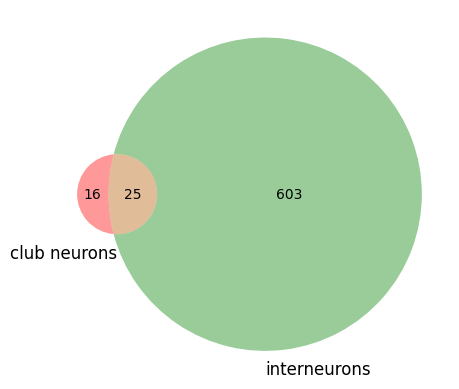

In [5]:
# Figure 6B - venn diagram (brain)
venn2(subsets = (len(postclub_df.post_pt_root_id.unique()) - len(intersected_list),
                 len(postinterneuron_df.post_pt_root_id.unique()) - len(intersected_list),
                 len(intersected_list)), set_labels = ('club neurons', 'interneurons'))
# plt.savefig('club_int_brain_postpartners.pdf', dpi = 300)
plt.show()

In [6]:
def filt_syn_df(syn_df, syn_thresh):
    
    indices_to_include = []

    # Find unique presynaptic neurons
    unique_pre_ids = syn_df.pre_pt_root_id.unique().tolist()

    # Loop through presynaptic neurons
    for i in unique_pre_ids:       
        pre_df = syn_df[syn_df.pre_pt_root_id == i]
        # Find unique postsynaptic neurons targeted by i-th presynaptic neuron
        unique_post_ids = pre_df.post_pt_root_id.unique().tolist() 
        # Loop through postsynaptic neurons
        for j in unique_post_ids:    
            # Is number of synapses onto j-th postsynaptic neuron larger than or equal to syn_thresh? 
            if sum(pre_df.post_pt_root_id == j) >= syn_thresh: 
                # Get indices (rows)
                indices = pre_df.index.values[pre_df.post_pt_root_id == j]       
                # Loop through indices 
                for k in indices:
                    # Append each index separately to avoid lists within list
                    indices_to_include.append(k)

    # Sort indices in ascending order
    indices_to_include.sort()
    
    # Create new syn_df with only connections above syn_thresh
    syn_df_filt = syn_df.loc[indices_to_include]
    
    return syn_df_filt

In [7]:
# Figure 6B - brain venn diagram 

# use FANC dataset in CAVE to query shared partners between ascending club and ascending
# 8B/10B neurons within the brain 

client = CAVEclient()

if not os.path.isfile(os.path.expanduser("~/.cloudvolume/secrets/cave-secret.json")):
    client.auth.get_new_token(open=True)

datastack_name = 'fanc_production_mar2021'

client = CAVEclient(datastack_name)

feco_df_all = client.materialize.query_table('feco_axons_v0')
downstream_feco_df_all = client.materialize.query_table('downstream_feco_axons_v1')

asc = downstream_feco_df_all[(downstream_feco_df_all.cell_type == '8B') | (downstream_feco_df_all.cell_type == '10B') & (downstream_feco_df_all.classification_system.str.contains('ascending'))  ]
t1l_asc = feco_df_all[(feco_df_all.classification_system == 'T1L') & (feco_df_all.cell_type == 'club_asc')]


# generate synapse dataframe for ascending club and 8B/10B neurons 
upstream = False
syn_thresh = 4
inputs = t1l_asc.pt_root_id.tolist()
if upstream == True:
    syn_df = client.materialize.synapse_query(post_ids = inputs)
else:
    syn_df = client.materialize.synapse_query(pre_ids = inputs)
    
syn_thresh = 4
synapse_df = filt_syn_df(syn_df, syn_thresh)
synapse_df

t1l_asc_df = synapse_df 

upstream = False
syn_thresh = 4
inputs = asc.pt_root_id.tolist()
if upstream == True:
    syn_df = client.materialize.synapse_query(post_ids = inputs)
else:
    syn_df = client.materialize.synapse_query(pre_ids = inputs)
    
syn_thresh = 4
synapse_df = filt_syn_df(syn_df, syn_thresh)
synapse_df

asc_df = synapse_df 

combined = set(list(t1l_asc_df.post_pt_root_id.unique().tolist())) & set(list(asc_df.post_pt_root_id.unique()))

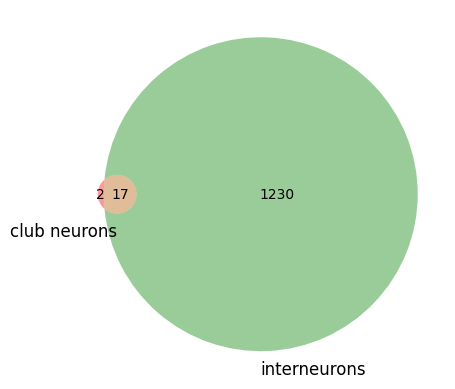

In [11]:
# Figure 6B - venn diagram (VNC) 
venn2(subsets = (len(t1l_asc_df.post_pt_root_id.unique()) - len(combined),
                 len(asc_df.post_pt_root_id.unique()) - len(combined),
                 len(combined)), set_labels = ('club neurons', 'interneurons'))
# plt.savefig('club_int_brain_postpartners.pdf', dpi = 300)
plt.show()

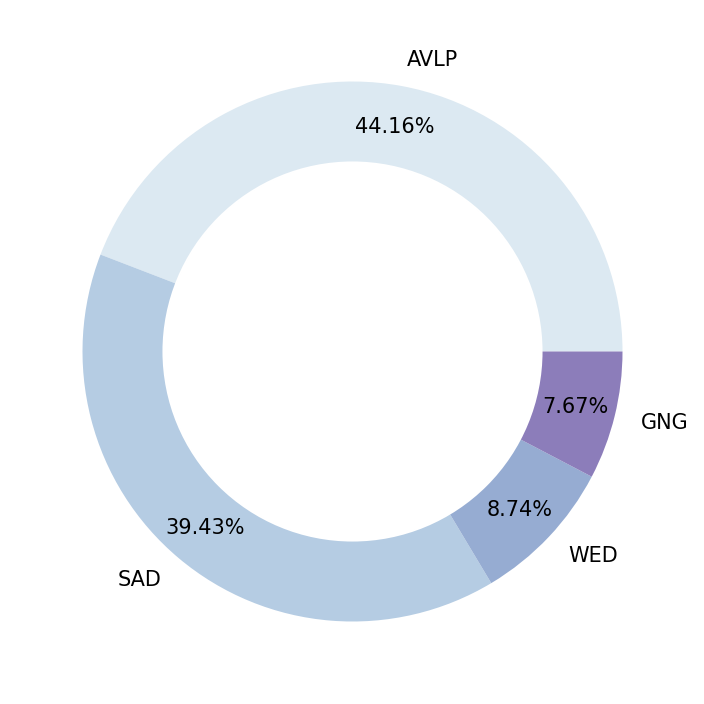

In [12]:
# Figure 6D - circle plots 

# query spatial distribution of synapses in each brain region 

# post synapses of club 
avlp_sum = np.sum(postclub_df[(postclub_df.neuropil == 'AVLP_R') | (postclub_df.neuropil == 'AVLP_L') & (postclub_df.syn_count >= 4)].syn_count)
sad_sum = np.sum(postclub_df[(postclub_df.neuropil == 'SAD') & (postclub_df.syn_count >= 4)].syn_count)
wed_sum = np.sum(postclub_df[(postclub_df.neuropil == 'WED_R') | (postclub_df.neuropil == 'WED_L') & (postclub_df.syn_count >= 4)].syn_count)
gng_sum = np.sum(postclub_df[(postclub_df.neuropil == 'GNG') & (postclub_df.syn_count >= 4)].syn_count)


import seaborn
plt.rcParams['figure.dpi'] = 150

data = [avlp_sum, sad_sum, wed_sum, gng_sum]
keys = ['AVLP', 'SAD', 'WED', 'GNG']
palette_color = seaborn.color_palette('BuPu')

plt.pie(data, labels = keys, autopct='%.2f%%', colors = palette_color, labeldistance = 1.1, pctdistance = 0.85)
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.tight_layout()

# plt.savefig('ascending_club_outputs_update.pdf', bbox_inches="tight")
plt.show()

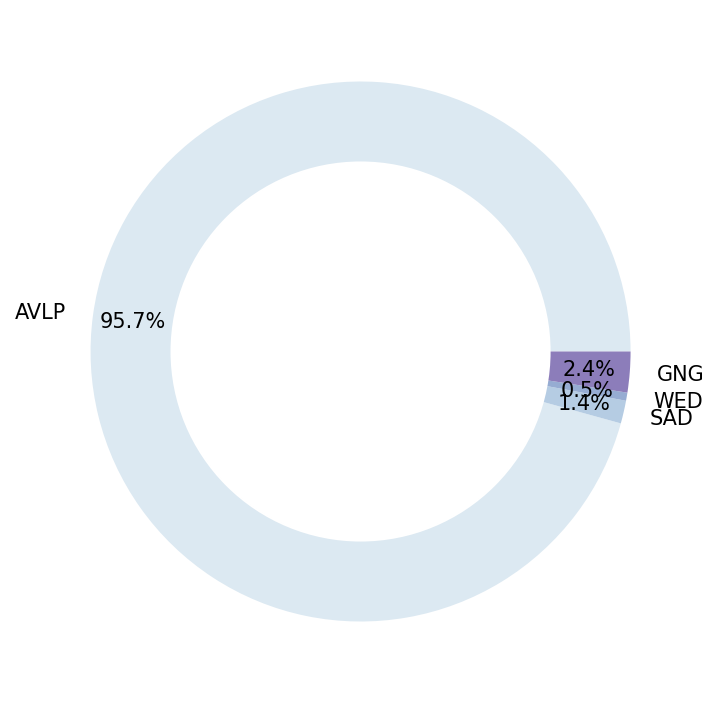

In [13]:
# Figure 6D - circle plots 

# query spatial distribution of synapses in each brain region 

# post synapses of interneurons 
avlp_sum = np.sum(postinterneuron_df[(postinterneuron_df.neuropil == 'AVLP_R') | (postinterneuron_df.neuropil == 'AVLP_L') & (postinterneuron_df.syn_count >= 4)].syn_count)
sad_sum = np.sum(postinterneuron_df[(postinterneuron_df.neuropil == 'SAD') & (postinterneuron_df.syn_count >= 4)].syn_count)
wed_sum = np.sum(postinterneuron_df[(postinterneuron_df.neuropil == 'WED_R') | (postinterneuron_df.neuropil == 'WED_L') & (postinterneuron_df.syn_count >= 4)].syn_count)
gng_sum = np.sum(postinterneuron_df[(postinterneuron_df.neuropil == 'GNG') & (postinterneuron_df.syn_count >= 4)].syn_count)


import seaborn
plt.rcParams['figure.dpi'] = 150

data = [avlp_sum, sad_sum, wed_sum, gng_sum]
keys = ['AVLP', 'SAD', 'WED', 'GNG']
palette_color = seaborn.color_palette('BuPu')

plt.pie(data, labels = keys, autopct='%.1f%%', colors = palette_color, labeldistance = 1.1, pctdistance = 0.85)
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.tight_layout()

# plt.savefig('ascending_club_outputs.pdf', bbox_inches="tight")
plt.show()

In [16]:
# get shared partners between ascending neurons and other sensory neurons in head 

# load in cell type classification dataset 

cell_types = pd.read_csv('classification783.csv')

olfactory = cell_types[cell_types['class'] == 'olfactory']
visual = cell_types[cell_types['class'] == 'visual']
mechanosensory = cell_types[cell_types['class'] == 'mechanosensory']
gustatory = cell_types[cell_types['class'] == 'gustatory']
thermosensory = cell_types[cell_types['class'] == 'thermosensory']
hygrosensory = cell_types[cell_types['class'] == 'hygrosensory']

# get dataframes of all postsynaptic partners of each sensory class 

olfactory_df = all_connections_df[(all_connections_df.pre_pt_root_id.isin(olfactory.root_id.tolist())) & (all_connections_df.syn_count >= 3)]
visual_df = all_connections_df[(all_connections_df.pre_pt_root_id.isin(visual.root_id.tolist())) & (all_connections_df.syn_count >= 3)]
mechanosensory_df = all_connections_df[(all_connections_df.pre_pt_root_id.isin(mechanosensory.root_id.tolist())) & (all_connections_df.syn_count >= 3)]
gustatory_df = all_connections_df[(all_connections_df.pre_pt_root_id.isin(gustatory.root_id.tolist())) & (all_connections_df.syn_count >= 3)]
thermosensory_df = all_connections_df[(all_connections_df.pre_pt_root_id.isin(thermosensory.root_id.tolist())) & (all_connections_df.syn_count >= 3)]
hygrosensory_df = all_connections_df[(all_connections_df.pre_pt_root_id.isin(hygrosensory.root_id.tolist())) & (all_connections_df.syn_count >= 3)]

# compare to postsynaptic partners of club neurons and 8B/10Bs 

# first club neurons 

shared_olfactory = shared_partners(postclub_df, olfactory_df) 
shared_visual= shared_partners(postclub_df, visual_df) 
shared_mechanosensory = shared_partners(postclub_df, mechanosensory_df) 
shared_gustatory = shared_partners(postclub_df, gustatory_df) 
shared_thermosensory = shared_partners(postclub_df, thermosensory_df) 
shared_hygrosensory = shared_partners(postclub_df, hygrosensory_df) 


print('shared partners between club neurons and other sensory')
print('olfactory', len(shared_olfactory))
print('visual', len(shared_visual))
print('gustatory', len(shared_gustatory))
print('mechanosensory', len(shared_mechanosensory))
print('thermosensory', len(shared_thermosensory))
print('hygrosensory', len(shared_hygrosensory))
print('          ')

# now 8B/10Bs 

shared_int_olfactory = shared_partners(postinterneuron_df, olfactory_df) 
shared_int_visual= shared_partners(postinterneuron_df, visual_df) 
shared_int_mechanosensory = shared_partners(postinterneuron_df, mechanosensory_df) 
shared_int_gustatory = shared_partners(postinterneuron_df, gustatory_df) 
shared_int_thermosensory = shared_partners(postinterneuron_df, thermosensory_df) 
shared_int_hygrosensory = shared_partners(postinterneuron_df, hygrosensory_df) 

print('shared partners between 8B/10B neurons and other sensory')
print('olfactory', len(shared_int_olfactory))
print('visual', len(shared_int_visual))
print('gustatory', len(shared_int_gustatory))
print('mechanosensory', len(shared_int_mechanosensory))
print('thermosensory', len(shared_int_thermosensory))
print('hygrosensory', len(shared_int_hygrosensory))


shared partners between club neurons and other sensory
olfactory 0
visual 0
gustatory 0
mechanosensory 17
thermosensory 0
hygrosensory 0
          
shared partners between 8B/10B neurons and other sensory
olfactory 0
visual 0
gustatory 1
mechanosensory 137
thermosensory 0
hygrosensory 0


In [15]:
mechanosensory.sub_class.unique().tolist()

eye_bristle = mechanosensory[mechanosensory.sub_class == 'eye bristle']
auditory = mechanosensory[mechanosensory.sub_class == 'auditory']
head_bristle = mechanosensory[mechanosensory.sub_class == 'head bristle']
taste_peg = mechanosensory[mechanosensory.sub_class == 'taste peg']
descending = mechanosensory[mechanosensory.sub_class == 'descending'] 
other_jo = mechanosensory[(~mechanosensory.root_id.isin(eye_bristle.root_id.tolist())) &\
               (~mechanosensory.root_id.isin(auditory.root_id.tolist())) &\
               (~mechanosensory.root_id.isin(head_bristle.root_id.tolist())) &\
               (~mechanosensory.root_id.isin(taste_peg.root_id.tolist())) &\
               (~mechanosensory.root_id.isin(descending.root_id.tolist()))]

eye_bristle_df = all_connections_df[(all_connections_df.pre_pt_root_id.isin(eye_bristle.root_id.tolist())) & (all_connections_df.syn_count >= 3)]
auditory_df = all_connections_df[(all_connections_df.pre_pt_root_id.isin(auditory.root_id.tolist())) & (all_connections_df.syn_count >= 3)]
head_bristle_df = all_connections_df[(all_connections_df.pre_pt_root_id.isin(head_bristle.root_id.tolist())) & (all_connections_df.syn_count >= 3)]
taste_peg_df = all_connections_df[(all_connections_df.pre_pt_root_id.isin(taste_peg.root_id.tolist())) & (all_connections_df.syn_count >= 3)]
descending_df = all_connections_df[(all_connections_df.pre_pt_root_id.isin(descending.root_id.tolist())) & (all_connections_df.syn_count >= 3)]
other_jo_df = all_connections_df[(all_connections_df.pre_pt_root_id.isin(other_jo.root_id.tolist())) & (all_connections_df.syn_count >= 3)]

# compare to postsynaptic partners of club neurons and 8B/10Bs 

# first club neurons 

shared_eye_bristle = shared_partners(postclub_df, eye_bristle_df) 
shared_auditory= shared_partners(postclub_df, auditory_df) 
shared_head_bristle = shared_partners(postclub_df, head_bristle_df) 
shared_taste_peg = shared_partners(postclub_df, taste_peg_df) 
shared_descending = shared_partners(postclub_df, descending_df) 
shared_other= shared_partners(postclub_df, other_jo_df) 


print('shared partners between club neurons and mechanosensory subclasses')
print('eye bristle', len(shared_eye_bristle))
print('auditory', len(shared_auditory))
print('head bristle', len(shared_head_bristle))
print('taste peg', len(shared_taste_peg))
print('descending', len(shared_descending))
print('other jo', len(shared_other))
print('          ')

# now 8B/10Bs 

# quantify shared partners that are overlapping 
shared_int_eye_bristle = shared_partners(postinterneuron_df, eye_bristle_df) 
shared_int_auditory= shared_partners(postinterneuron_df, auditory_df) 
shared_int_head_bristle = shared_partners(postinterneuron_df, head_bristle_df) 
shared_int_taste_peg = shared_partners(postinterneuron_df, taste_peg_df) 
shared_int_descending = shared_partners(postinterneuron_df, descending_df) 
shared_int_other = shared_partners(postinterneuron_df, other_jo_df)

print('shared partners between club neurons and mechanosensory subclasses')
print('eye bristle', len(shared_int_eye_bristle))
print('auditory', len(shared_int_auditory))
print('head bristle', len(shared_int_head_bristle))
print('taste peg', len(shared_int_taste_peg))
print('descending', len(shared_int_descending))
print('other jo', len(shared_int_other))


shared partners between club neurons and mechanosensory subclasses
eye bristle 0
auditory 16
head bristle 0
taste peg 0
descending 0
other jo 9
          
shared partners between club neurons and mechanosensory subclasses
eye bristle 0
auditory 121
head bristle 0
taste peg 0
descending 8
other jo 68


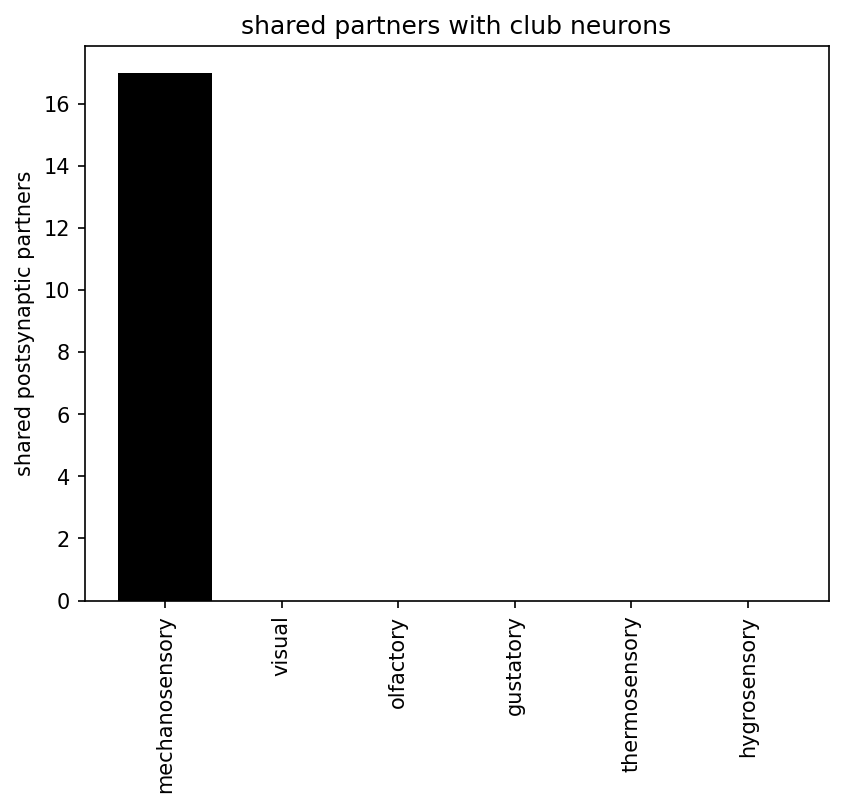

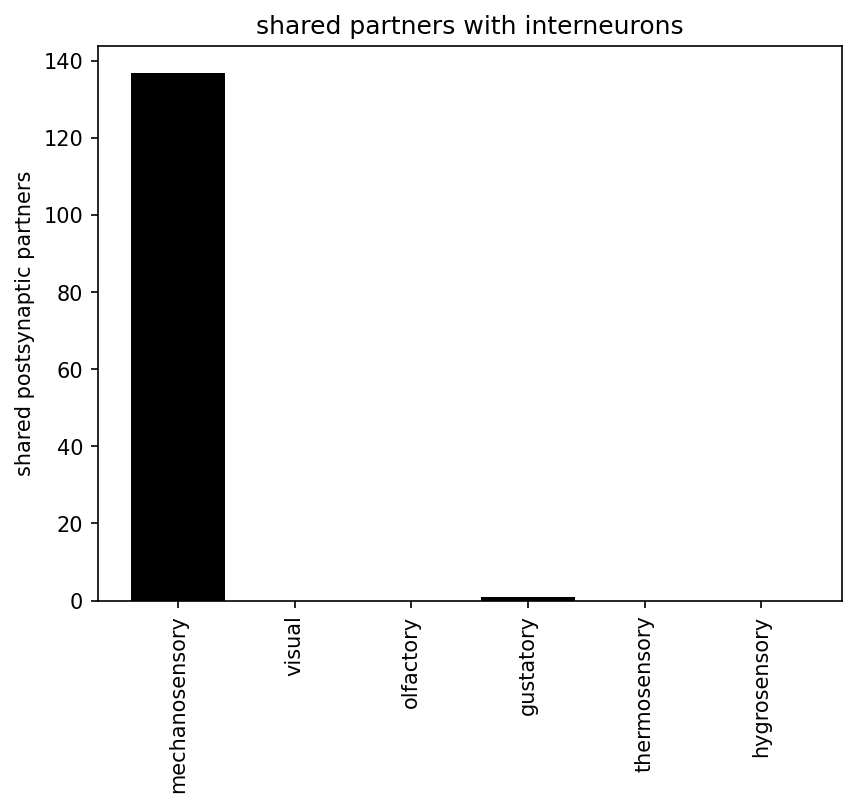

In [17]:
# Figure 6E - plot stacked bar plots 

# create data
x = ['mechanosensory', 'visual', 'olfactory', 'gustatory', 'thermosensory', 'hygrosensory']
y1 = [len(shared_mechanosensory), len(shared_visual), len(shared_olfactory), len(shared_gustatory), len(shared_thermosensory), len(shared_hygrosensory)]
 
# plot bars in stack manner
plt.figure(1)
plt.bar(x, y1, color= '#000000')
plt.xticks(rotation=90)
plt.ylabel('shared postsynaptic partners')
plt.title('shared partners with club neurons')
# plt.savefig('club_sensory_shared_partners_brain.pdf', dpi = 300)
plt.show()


# plot stacked bar plots 
# create data
x2 = ['mechanosensory', 'visual', 'olfactory', 'gustatory', 'thermosensory', 'hygrosensory']
y3 = [len(shared_int_mechanosensory), len(shared_int_visual), len(shared_int_olfactory), len(shared_int_gustatory), len(shared_int_thermosensory), len(shared_int_hygrosensory)]
 
# plot bars in stack manner
plt.figure(2)
plt.bar(x2, y3, color= '#000000')
plt.xticks(rotation=90)
plt.ylabel('shared postsynaptic partners')
# plt.ylim([0, 75])
plt.title('shared partners with interneurons')
# plt.savefig('int_sensory_shared_partners_brain.pdf', dpi = 300)
plt.show()

In [18]:
other_jons = mechanosensory[mechanosensory.sub_class.isnull()]

# mechano_connections = all_connections_df[all_connections_df.pre_root_id.isin(club_neurons) | \
#                                          all_connections_df.pre_root_id.isin(interneurons) | \
#                                          all_connections_df.pre_root_id.isin(mechanosensory.root_id.tolist())]
mechano_connections = all_connections_df[all_connections_df.pre_pt_root_id.isin(club_neurons) | \
                                         all_connections_df.pre_pt_root_id.isin(mechanosensory.root_id.tolist())]

# constrain to partners that is postsynaptic to club_neurons 
sensory_name = [] 

for idx in mechano_connections.pre_pt_root_id.tolist(): 
    if idx in club_neurons: 
        sensory_name.append('club')
    
    elif idx in interneurons: 
        sensory_name.append('8B/10B')
    
    elif idx in other_jons.root_id.tolist(): 
        sensory_name.append(other_jons[other_jons.root_id == idx].cell_type.tolist()[0])
    
    elif idx in mechanosensory.root_id.tolist(): 
         sensory_name.append(mechanosensory[mechanosensory.root_id == idx].sub_class.tolist()[0])
        
mechano_connections['sensory_name'] = sensory_name
    

/var/folders/ds/x7td6nf906g264l63pfg2zz40000gn/T/ipykernel_1450/3392051868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mechano_connections['sensory_name'] = sensory_name


In [20]:
other_jons = mechanosensory[mechanosensory.sub_class.isnull()]

# mechano_connections = all_connections_df[all_connections_df.pre_root_id.isin(club_neurons) | \
#                                          all_connections_df.pre_root_id.isin(interneurons) | \
#                                          all_connections_df.pre_root_id.isin(mechanosensory.root_id.tolist())]
all_connections_df = all_connections_df[all_connections_df.syn_count>=3]
club_connections = all_connections_df[all_connections_df.pre_pt_root_id.isin(club_neurons)]
# club_connections = all_connections_df[all_connections_df.pre_root_id.isin(club_neurons)]
club_shared_connections = all_connections_df[all_connections_df.post_pt_root_id.isin(club_connections.post_pt_root_id.tolist())]
club_shared_connections = club_shared_connections[club_shared_connections.pre_pt_root_id.isin(club_neurons) | club_shared_connections.pre_pt_root_id.isin(mechanosensory.root_id.tolist())]

# constrain to partners that is postsynaptic to club_neurons 
sensory_name = [] 

for idx in club_shared_connections.pre_pt_root_id.tolist(): 
    if idx in club_neurons: 
        sensory_name.append('1_club')
    
    elif idx in interneurons: 
        sensory_name.append('8B/10B')
    
    elif idx in other_jons.root_id.tolist(): 
        sensory_name.append(other_jons[other_jons.root_id == idx].cell_type.tolist()[0])
    
    elif idx in auditory.root_id.tolist(): 
        sensory_name.append(mechanosensory[mechanosensory.root_id == idx].cell_type.tolist()[0])

    elif idx in mechanosensory.root_id.tolist(): 
        sensory_name.append(mechanosensory[mechanosensory.root_id == idx].sub_class.tolist()[0])
        
club_shared_connections['sensory_name'] = sensory_name

Text(0.5, 70.86666666666666, 'interneurons')

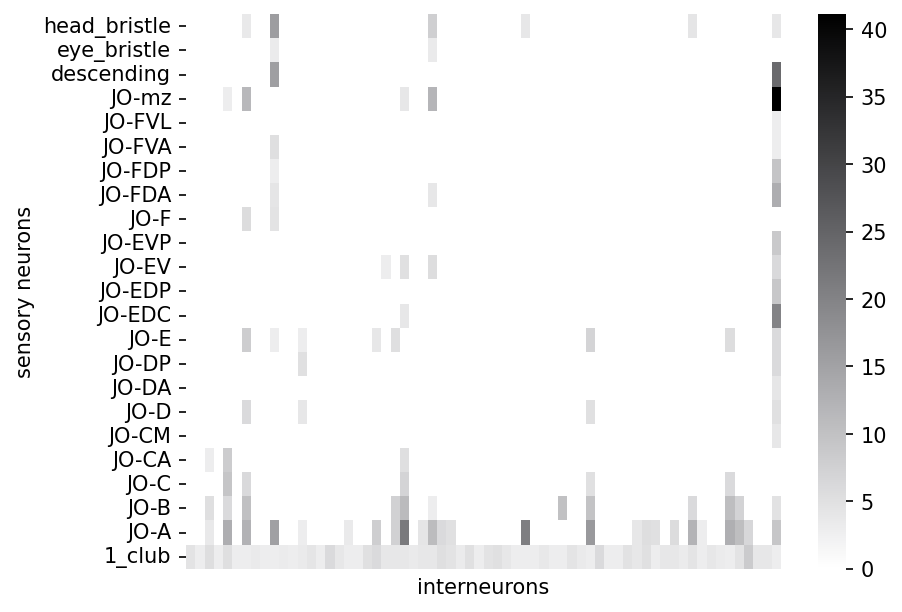

In [21]:
import numpy as np 
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

# create a sparse matrix.... 
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=1, dark=0, as_cmap=True) #black and white colormap 
piv = pd.pivot_table(club_shared_connections, values="syn_count",index=["sensory_name"], columns=["post_pt_root_id"], fill_value=0)
sns.heatmap(piv.sort_values(by = 'sensory_name', ascending = False), cmap = cmap, xticklabels = [])
plt.rcParams['font.size'] = '5'
plt.ylabel('sensory neurons')
plt.xlabel('interneurons')
# plt.savefig('club_head_sensory_overlap_update.pdf', bbox_inches='tight', dpi = 300)



In [22]:
# all_connections_df = all_connections_df[all_connections_df.syn_count>=3]
int_connections = all_connections_df[all_connections_df.pre_pt_root_id.isin(interneurons)]
int_shared_connections = all_connections_df[all_connections_df.post_pt_root_id.isin(int_connections.post_pt_root_id.tolist())]
int_shared_connections = int_shared_connections[int_shared_connections.pre_pt_root_id.isin(interneurons) | int_shared_connections.pre_pt_root_id.isin(mechanosensory.root_id.tolist())]

# constrain to partners that is postsynaptic to club_neurons 
sensory_name = [] 

for idx in int_shared_connections.pre_pt_root_id.tolist(): 
    if idx in club_neurons: 
        sensory_name.append('club')
    
    elif idx in interneurons: 
        sensory_name.append('8B/10B')
    
    elif idx in other_jons.root_id.tolist(): 
        sensory_name.append(other_jons[other_jons.root_id == idx].cell_type.tolist()[0])
    
    elif idx in auditory.root_id.tolist(): 
        sensory_name.append(mechanosensory[mechanosensory.root_id == idx].cell_type.tolist()[0])

    elif idx in mechanosensory.root_id.tolist(): 
        sensory_name.append(mechanosensory[mechanosensory.root_id == idx].sub_class.tolist()[0])
        
int_shared_connections['sensory_name'] = sensory_name

Text(0.5, 70.86666666666666, 'interneurons')

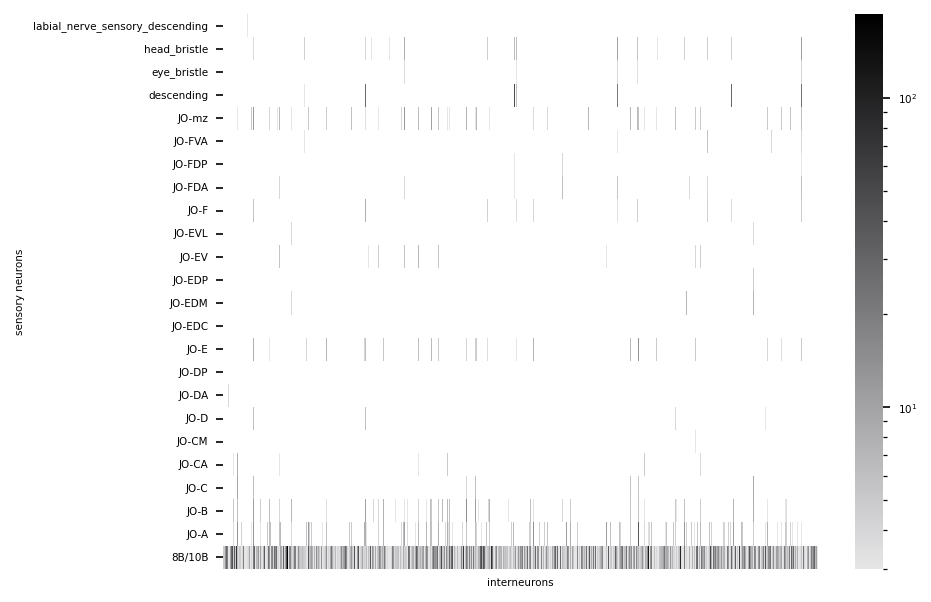

In [23]:
# create a sparse matrix.... 
from matplotlib.colors import LogNorm, Normalize

cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True) #black and white colormap 
piv = pd.pivot_table(int_shared_connections, values="syn_count",index=["sensory_name"], columns=["post_pt_root_id"], fill_value=0)
sns.heatmap(piv.sort_values(by = 'sensory_name', ascending = False), vmin = 0, vmax = 30, cmap = cmap, xticklabels = [], norm = LogNorm())
plt.rcParams['font.size'] = '5'
plt.ylabel('sensory neurons')
plt.xlabel('interneurons')
# plt.savefig('interneuron_sensory_overlap_update.pdf', bbox_inches='tight', dpi = 300)


In [24]:
eye_bristle = mechanosensory[mechanosensory.sub_class == 'eye bristle']
auditory = mechanosensory[mechanosensory.sub_class == 'auditory']
head_bristle = mechanosensory[mechanosensory.sub_class == 'head bristle']
taste_peg = mechanosensory[mechanosensory.sub_class == 'taste peg']
descending = mechanosensory[mechanosensory.sub_class == 'descending'] 

other_jo = mechanosensory[(~mechanosensory.root_id.isin(eye_bristle.root_id.tolist())) &\
               (~mechanosensory.root_id.isin(auditory.root_id.tolist())) &\
               (~mechanosensory.root_id.isin(head_bristle.root_id.tolist())) &\
               (~mechanosensory.root_id.isin(taste_peg.root_id.tolist())) &\
               (~mechanosensory.root_id.isin(descending.root_id.tolist()))]